<a href="https://colab.research.google.com/github/Parkdongmin47/F2_-.ipynb./blob/main/F2_%EB%B0%95%EB%8F%99%EB%AF%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import sys

# 코랩의 경우 깃허브 저장소로부터 utils.py를 다운로드 합니다.
if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
    !mkdir -p notebooks
    !mv utils.py notebooks

--2024-06-14 01:34:21--  https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 771 [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]     771  --.-KB/s    in 0s      

2024-06-14 01:34:21 (29.4 MB/s) - ‘utils.py’ saved [771/771]



In [4]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

from scipy.stats import norm

from notebooks.utils import display

In [5]:
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 5
BETA = 500

In [6]:
# 데이터 로드
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [7]:
# 데이터 전처리
def preprocess(imgs):
    """
    이미지 정규화 및 크기 변경
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

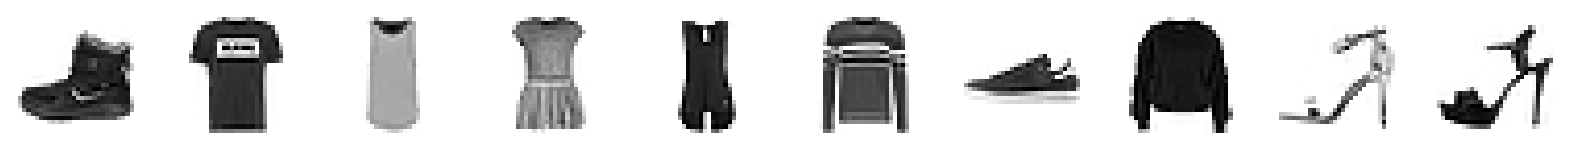

In [8]:
# 훈련 세트의 일부 의류 항목 표시
display(x_train)

In [9]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [10]:
# 인코더
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, 1), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # 디코더에 필요합니다!

x = layers.Flatten()(x)
z_mean = layers.Dense(EMBEDDING_DIM, name="z_mean")(x)
z_log_var = layers.Dense(EMBEDDING_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 8, 8, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 4, 4, 128)            73856     ['conv2d_1[0][0]']            
                                                                                            

In [11]:
# 디코더
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         147584    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 32, 32, 32)        18464 

In [12]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """특정 입력에서 모델을 호출합니다."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """훈련 스텝을 실행합니다."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                BETA
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def get_config(self):
        return {}

In [13]:
# 변이형 오토인코더 생성
vae = VAE(encoder, decoder)

In [14]:
# 변이형 오토인코더 컴파일
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

In [15]:
# 모델 저장 체크포인트 생성
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [ ]:
vae.fit(
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/5
600/600 [==============================] - ETA: 0s - total_loss: 160.5061 - reconstruction_loss: 156.0779 - kl_loss: 4.4283

600/600 [==============================] - 207s 339ms/step - total_loss: 160.5061 - reconstruction_loss: 156.0779 - kl_loss: 4.4283 - val_loss: 140.0876 - val_reconstruction_loss: 135.0075 - val_kl_loss: 5.0801
Epoch 2/5
600/600 [==============================] - ETA: 0s - total_loss: 135.3204 - reconstruction_loss: 130.3306 - kl_loss: 4.9897

600/600 [==============================] - 214s 357ms/step - total_loss: 135.3204 - reconstruction_loss: 130.3306 - kl_loss: 4.9897 - val_loss: 137.5183 - val_reconstruction_loss: 132.4574 - val_kl_loss: 5.0609
Epoch 3/5
600/600 [==============================] - ETA: 0s - total_loss: 133.6854 - reconstruction_loss: 128.6657 - kl_loss: 5.0197

600/600 [==============================] - 203s 337ms/step - total_loss: 133.6854 - reconstruction_loss: 128.6657 - kl_loss: 5.0197 - val_loss: 136.2613 - val_reconstruction_loss: 131.1716 - val_kl_loss: 5.0898
Epoch 4/5
600/600 [==============================] - ETA: 0s - total_loss: 132.8726 - reconstruction_loss: 127.8310 - kl_loss: 5.0416

600/600 [==============================] - 204s 341ms/step - total_loss: 132.8726 - reconstruction_loss: 127.8310 - kl_loss: 5.0416 - val_loss: 136.5000 - val_reconstruction_loss: 131.3123 - val_kl_loss: 5.1877
Epoch 5/5
600/600 [==============================] - ETA: 0s - total_loss: 132.4082 - reconstruction_loss: 127.3218 - kl_loss: 5.0864

600/600 [==============================] - 217s 361ms/step - total_loss: 132.4082 - reconstruction_loss: 127.3218 - kl_loss: 5.0864 - val_loss: 135.3286 - val_reconstruction_loss: 130.1445 - val_kl_loss: 5.1841


In [ ]:
# 최종 모델 저장
vae.save("./models/vae")
encoder.save("./models/encoder")
decoder.save("./models/decoder")

In [17]:
# 테스트셋의 일부를 선택합니다.
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

157/157 [==============================] - 8s 49ms/step
실제 의류 아이템


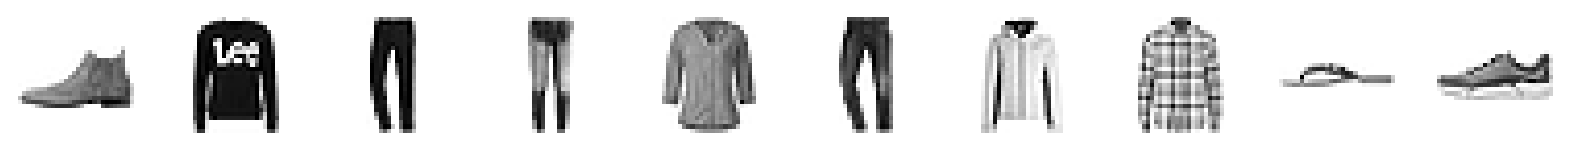

재구성 이미지


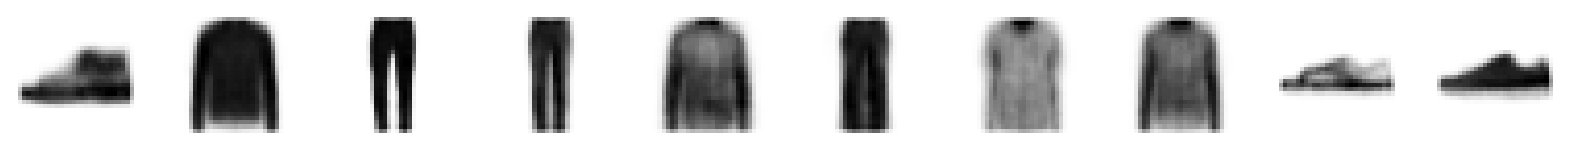

In [ ]:
# 오토인코더 예측을 만들고 출력합니다.
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("실제 의류 아이템")
display(example_images)
print("재구성 이미지")
display(reconstructions)

In [ ]:

# 예제 이미지 인코딩
z_mean, z_var, z = encoder.predict(example_images)

157/157 [==============================] - 1s 6ms/step


In [ ]:

# 임베딩의 몇 가지 예
print(z[:10])

[[-1.2605988   0.7386191 ]
 [ 0.40428632 -1.1942056 ]
 [ 2.9636183   0.69175166]
 [ 1.8861217   1.7156788 ]
 [ 0.12523308 -0.46082836]
 [ 1.7294502   0.3104612 ]
 [ 0.26950848  0.976234  ]
 [ 0.15477209  0.23452896]
 [-2.3334558  -0.01399206]
 [-2.2736042  -0.8462017 ]]


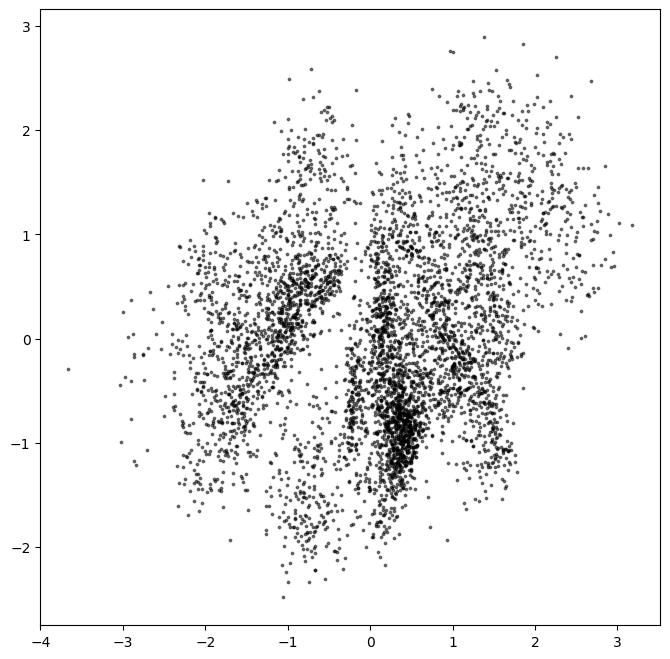

In [ ]:
# 2D 공간에서 인코딩된 포인트 표시
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

In [18]:
# 표준 정규 분포에서 잠재 공간의 일부 포인트를 샘플링합니다.
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))

In [ ]:

# 샘플링된 포인트 디코딩
reconstructions = decoder.predict(z_sample)

1/1 [==============================] - 0s 370ms/step


In [ ]:

# 원본 임베딩과 샘플링된 임베딩을 p값으로 변환하기
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

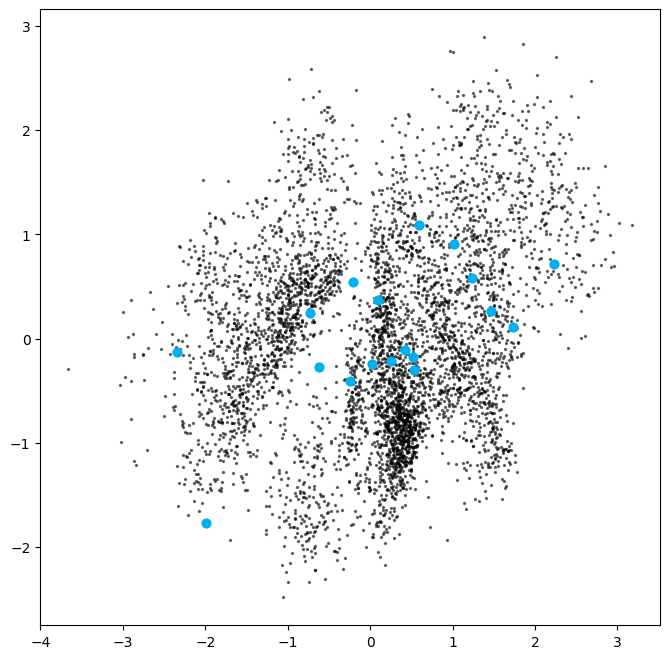

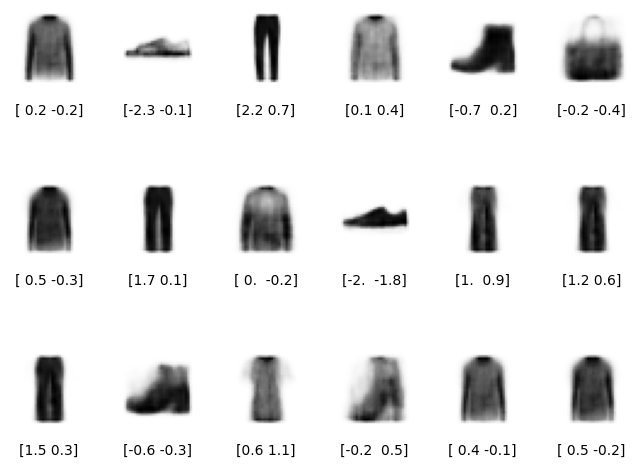

In [ ]:
# 그래프를 그립니다....
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... 원본 임베딩 ...
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# ... 잠재 공간에 새로 생성된 포인트
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# 디코딩된 이미지 그리드를 추가합니다.
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

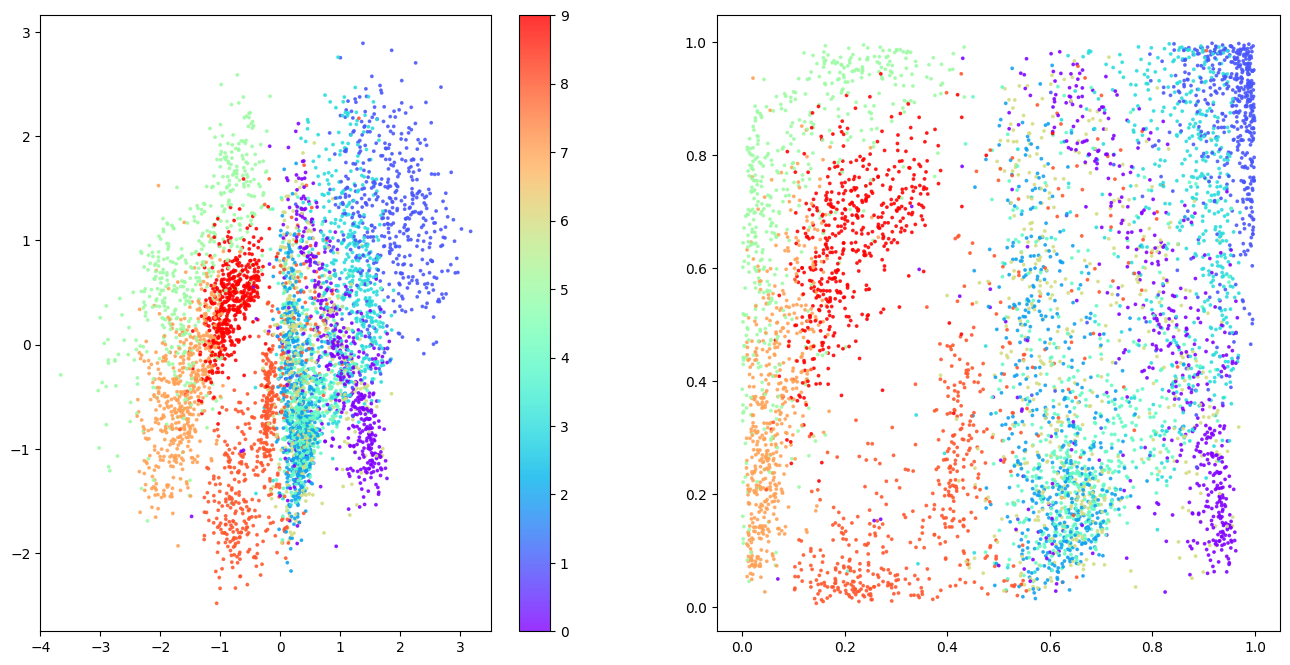

In [ ]:
# 레이블(의류 종류)에 따라 임베딩에 색상을 지정합니다.
figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.show()

8/8 [==============================] - 0s 36ms/step


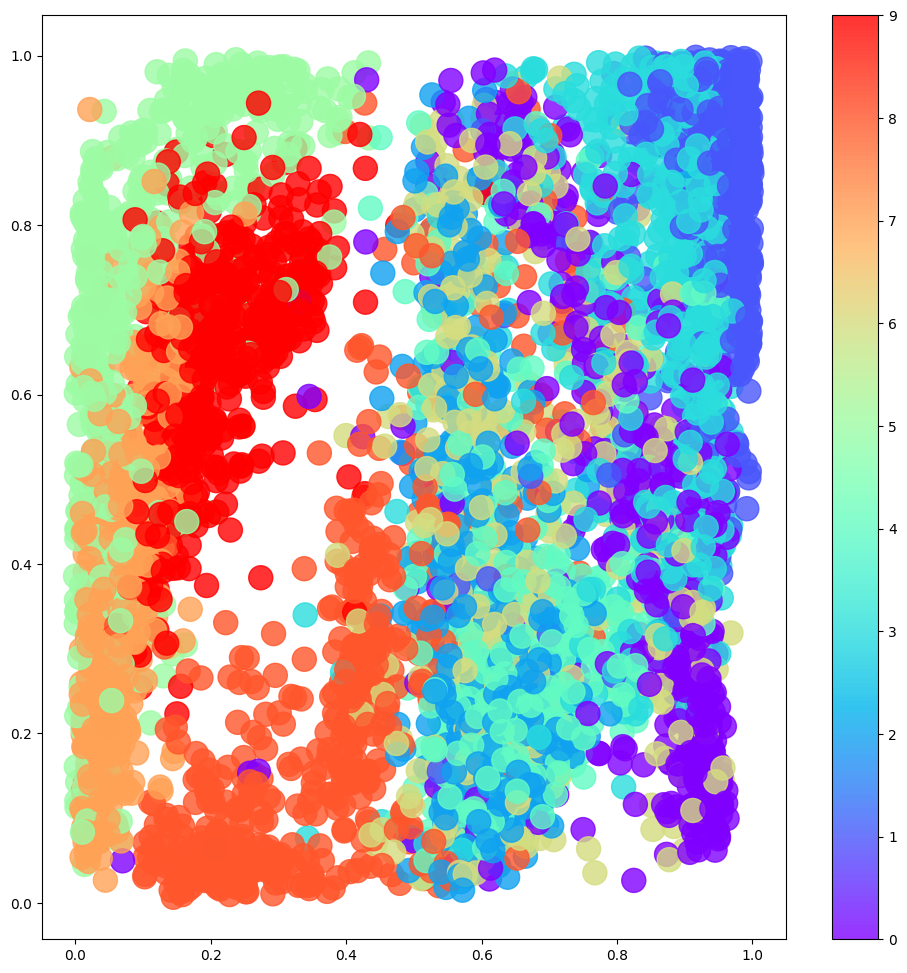

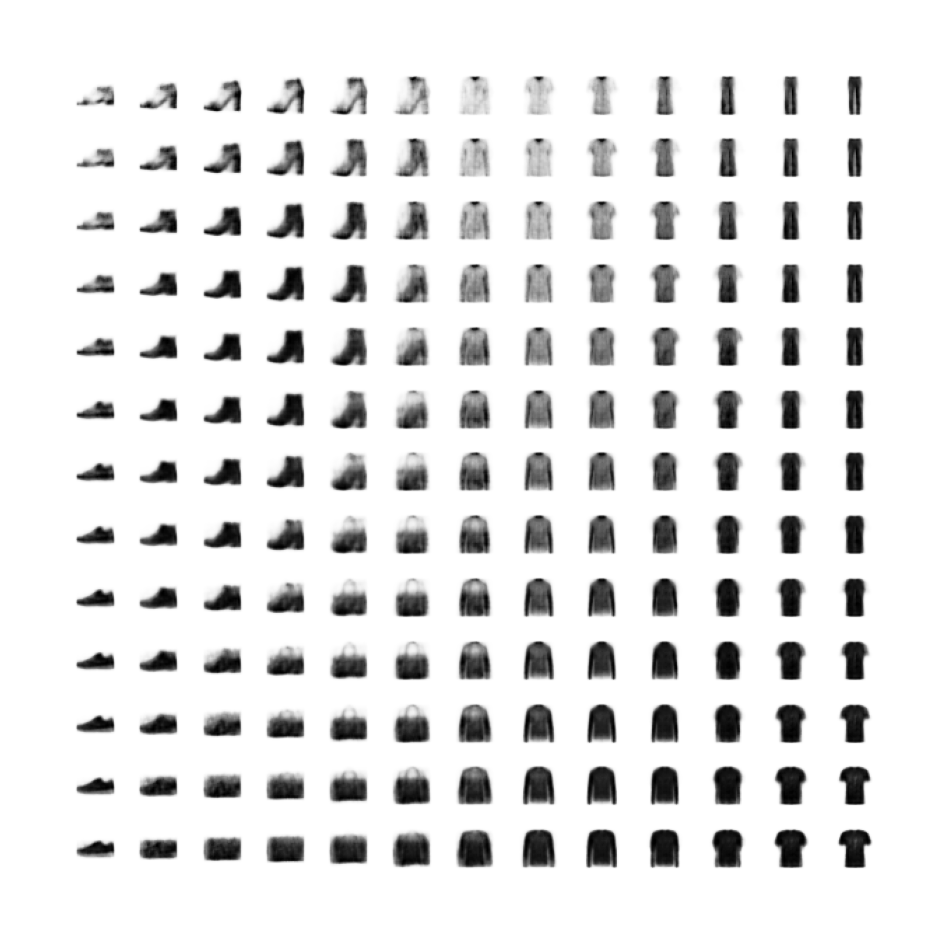

In [ ]:
# 레이블(의류 종류)에 따라 임베딩에 색상을 지정합니다.
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=300
)
plt.colorbar()

x = norm.ppf(np.linspace(0, 1, grid_size))
y = norm.ppf(np.linspace(1, 0, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

1/1 [==============================] - 0s 483ms/step


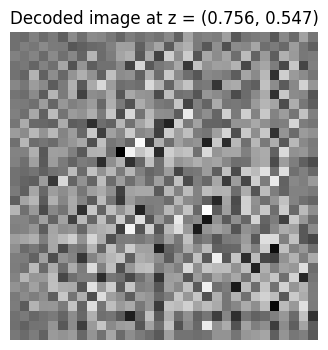

In [19]:
specified_point = np.array([[0.756, 0.547]])  # (1, 2) 형식의 numpy 배열로 정의
decoded_image = decoder.predict(specified_point)

# 시각화
plt.figure(figsize=(4, 4))
plt.imshow(decoded_image[0].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='Greys')
plt.title("Decoded image at z = (0.756, 0.547)")
plt.axis('off')  # 축 숨김
plt.show()

1/1 [==============================] - 0s 24ms/step


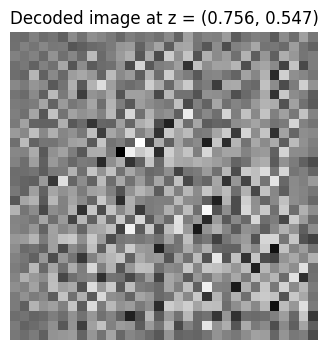

In [20]:
specified_point = np.array([[0.865, 0.456]])  # (1, 2) 형식의 numpy 배열로 정의
decoded_image = decoder.predict(specified_point)

# 시각화
plt.figure(figsize=(4, 4))
plt.imshow(decoded_image[0].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='Greys')
plt.title("Decoded image at z = (0.756, 0.547)")
plt.axis('off')  # 축 숨김
plt.show()

1/1 [==============================] - 0s 89ms/step


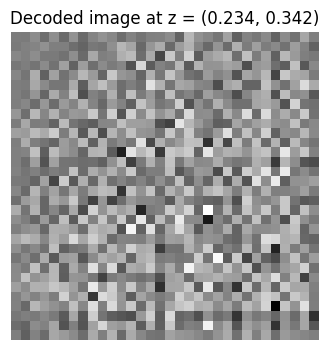

In [22]:
specified_point = np.array([[0.234, 0.342]])  # (1, 2) 형식의 numpy 배열로 정의
decoded_image = decoder.predict(specified_point)

# 시각화
plt.figure(figsize=(4, 4))
plt.imshow(decoded_image[0].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='Greys')
plt.title("Decoded image at z = (0.234, 0.342)")
plt.axis('off')  # 축 숨김
plt.show()

1/1 [==============================] - 0s 163ms/step


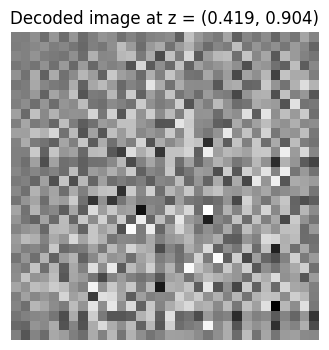

In [23]:
specified_point = np.array([[0.419, 0.904]])  # (1, 2) 형식의 numpy 배열로 정의
decoded_image = decoder.predict(specified_point)

# 시각화
plt.figure(figsize=(4, 4))
plt.imshow(decoded_image[0].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='Greys')
plt.title("Decoded image at z = (0.419, 0.904)")
plt.axis('off')  # 축 숨김
plt.show()

1/1 [==============================] - 0s 37ms/step


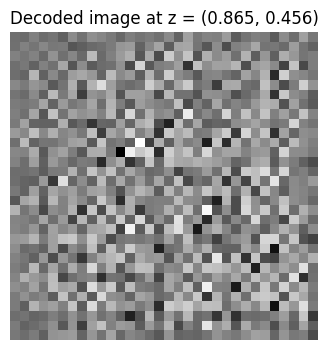

In [24]:
specified_point = np.array([[0.865, 0.456]])  # (1, 2) 형식의 numpy 배열로 정의
decoded_image = decoder.predict(specified_point)

# 시각화
plt.figure(figsize=(4, 4))
plt.imshow(decoded_image[0].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='Greys')
plt.title("Decoded image at z = (0.865, 0.456)")
plt.axis('off')  # 축 숨김
plt.show()